# Week 6 worked example 2
## Linearized supersonic flow

Dr. Daniel Duke<br>
Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)<br>
Department of Mechanical & Aerospace Engineering<br>
Monash University, Australia

Calculate the lift and wave-drag coefficients for flow over a flat plate and compare to the results of ideal shock-expansion theory.

Linearized theory for flat plates:
$$
\begin{align}
    c_l = \frac{4 \alpha}{\sqrt{M_\infty^2 - 1}}\\
    c_d = \frac{4 \alpha^2}{\sqrt{M_\infty^2 - 1}}\\
\end{align}
$$

Ideal shock expansion theory - there will be an expansion fan on the upper surface leading edge and an  oblique shock on the lower surface leading edge. The solution procedure is:

Find the presssure downstream of the oblique shock:
$$
\begin{align}
    \tan \theta = \tan \alpha = 2 \cot \beta \frac{ M_1^2 \sin^2 \beta - 1} {M_1^2 \left( \gamma + \cos 2 \beta \right) + 2 }\\
    \\
    \frac{p_3}{p_\infty} = \frac{2 \gamma M_\infty^2 \sin^2 \beta - (\gamma-1)}{\gamma + 1}\\
\end{align}
$$

Find the pressure downstream of the expansion fan:
$$
\begin{align}
    \alpha = \nu(M_2) - \nu(M_\infty)\\
    \\
    p_0 = p_\infty \left( 1 + \frac{\gamma - 1}{2} M_\infty^2 \right)^{\frac{\gamma}{\gamma-1}}\\
    \\
    p_2 = p_0 \left( 1 + \frac{\gamma - 1}{2} M_2^2 \right)^{\frac{-\gamma}{\gamma-1}}\\
\end{align}
$$

Solve for the lift and drag coefficients
$$
\begin{align}
    c_l = \frac{2 (p_3 - p_2)}{\gamma p_1 M_\infty^2}\\
    \\
    c_d = c_l \frac{\sin \alpha}{\cos \alpha}
\end{align}
$$





In [1]:
# Import python libraries
import numpy as np
import scipy.optimize as sopt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

In [21]:
# Define constants
gamma = 1.4 # air
Minf_max = 10.

# Define variables
Minf = np.logspace(0,np.log10(Minf_max),32) + 0.05
AoA_slider=widgets.FloatSlider(min=0,max=20,step=0.2,value=5.0)

In [23]:
# Functions for the oblique shock equations. 

# Cotangent - Radians
def cot(theta): return 1.0/np.tan(theta+1e-12)

# Oblique tan(theta) = f(beta,M1,gamma) , beta in radians
def oblique_tantheta(beta, M1, gamma):
    return 2*cot(beta)*(M1**2 * np.sin(beta)**2 - 1)/(M1**2 * (gamma + np.cos(2*beta))+2)

# Oblique beta(theta,M1,gamma), theta and beta in degrees.
def oblique_beta(theta, M1, gamma):

    # this function has a root for correct pair of beta and theta.
    # angles in radians
    def zerofun(beta,theta,M1,gamma):
        return np.arctan(oblique_tantheta(beta,M1,gamma)) - theta
    
    # Find roughly the beta value at theta_max
    beta_scan = np.linspace(0,np.pi/2.,50)
    zscan = np.arctan(zerofun(beta_scan,0,M1,gamma))
    imax = np.where(zscan==np.nanmax(zscan))[0][0]
    beta_max = beta_scan[imax]
    root = np.nan
    loops = 0
    
    # Find the root of the function.
    while (np.isnan(root) & (beta_max <= 1.6)):
        try:
            root = sopt.brentq(zerofun, 1e-3, beta_max, args=(theta*np.pi/180.,M1,gamma)) 
        except ValueError:
            root = np.nan
            beta_max += 0.1
        loops += 1
    
    return root * 180./np.pi

# p2/p1 across oblique shock, beta in degrees
def oblique_pressure_ratio(beta, M1, gamma):
    return (2*gamma*(M1**2)*np.sin(beta*np.pi/180.)**2 - (gamma-1))/(gamma+1)

In [4]:
# Functions for expansion fans and ideal shock expansion theory.

def stagn_pressure_ratio(gamma,M):
    return (1 + 0.5*(gamma-1)*M**2)**(gamma/(gamma-1))

# AoA alpha in degrees
def ideal_shock_cl_cd(pl_pinf,pu_pinf,M,gamma,alpha):
    cl = (2/(gamma*M**2)) * ( pl_pinf - pu_pinf )
    cd = cl * np.tan(alpha *np.pi/180. )
    return cl,cd

# Return nu in degrees
def prandtl_meyer(M,gamma):
    A = np.sqrt((gamma+1.)/(gamma-1.))
    B = np.sqrt((M**2 - 1.)*(gamma-1.)/(gamma+1.))
    C = np.sqrt(M**2 - 1.)
    nu = A * np.arctan(B) - np.arctan(C)
    return nu * 180. / np.pi

In [26]:
# Ideal shock expansion theory
# Routine to solve for cl, cd for a range of mach numbers at fixed angle of attack
def run_calcs_ideal(M1_range, alpha, gamma):
    
    cl_all = []
    cd_all = []
    
    for M1 in M1_range:
    
        # Solve across oblique shock.
        beta = oblique_beta(alpha, M1, gamma)
        pl_pinf = oblique_pressure_ratio(beta, M1, gamma)

        # Solve across expansion fan.
        nu1 = prandtl_meyer(M1, gamma)
        nu2 = alpha + nu1
        fsolveM2 = lambda M: prandtl_meyer(M,gamma)-nu2
        try:
            # find where nu(M2) - nu2 == 0
            M2 = sopt.brentq(fsolveM2, 1.0, 50.0)
        except ValueError:
            M2 = np.nan
        
        p0_pinf = stagn_pressure_ratio(gamma,M1)
        p0_p2 = stagn_pressure_ratio(gamma,M2)
        pu_pinf = p0_pinf / p0_p2

        # Solve ideal shock-expansion cl and cd.
        cl, cd = ideal_shock_cl_cd(pl_pinf,pu_pinf,M1,gamma,alpha)
        
        cl_all.append(cl); cd_all.append(cd)
        
    return np.array(cl_all), np.array(cd_all)
        

In [6]:
# Linearized supersonic theory
def run_calcs_lin(M1_range, alpha, gamma):
    lam = np.sqrt((M1_range+1e-9)**2 - 1)
    cl = (4.*alpha*np.pi/180.)/lam
    cd = (4.*((alpha*np.pi/180.)**2))/lam
    return cl, cd

<IPython.core.display.Javascript object>


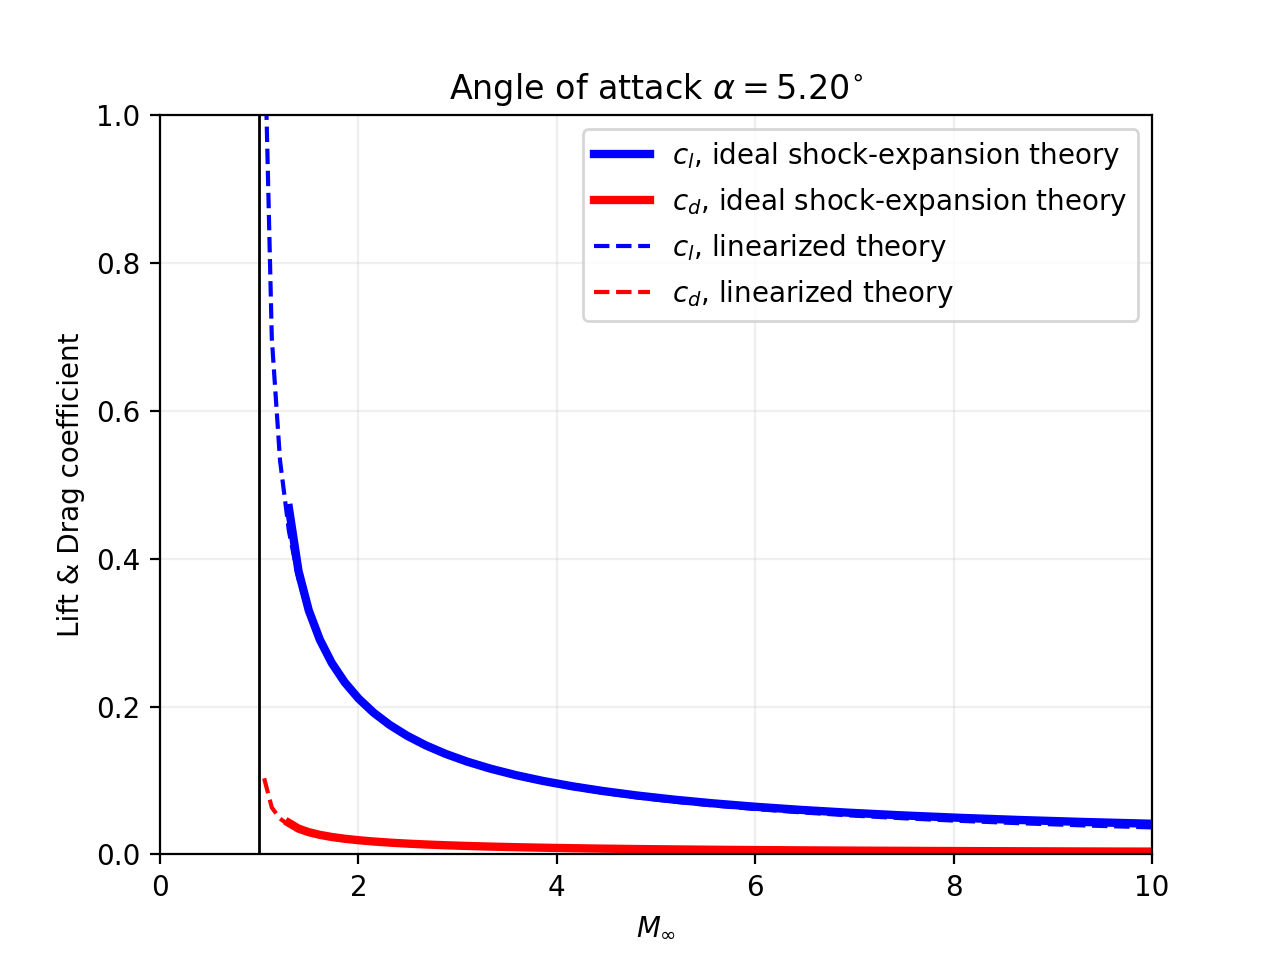

interactive(children=(FloatSlider(value=20.0, description='alpha', max=20.0, step=0.2), Output()), _dom_classe…

In [27]:
# Main solver

# set up 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Angle of attack $\alpha = %.2f^{\circ}$" % AoA_slider.value)
plt.grid(alpha=.2)
plt.xlabel("$M_\infty$")
plt.ylabel("Lift & Drag coefficient")
plt.axhline(0,c='k',lw=1)
plt.axvline(1,c='k',lw=1)
plt.xlim(0,10)
plt.ylim(0,)

# calculate cl,cd
cl1,cd1 = run_calcs_ideal(Minf, AoA_slider.value, gamma)
cl2,cd2 = run_calcs_lin(Minf, AoA_slider.value, gamma)

# now plot
g1,=ax.plot(Minf, cl1,label='$c_l$, ideal shock-expansion theory', ls='-', c='b', lw=3)
g2,=ax.plot(Minf, cd1,label='$c_d$, ideal shock-expansion theory', ls='-', c='r', lw=3)
g3,=ax.plot(Minf, cl2,label='$c_l$, linearized theory', ls='--', c='b')
g4,=ax.plot(Minf, cd2,label='$c_d$, linearized theory', ls='--', c='r')

#plt.yscale('log')
plt.legend()

def update_graph(alpha):

    # recalculate cl,cd
    cl1,cd1 = run_calcs_ideal(Minf, AoA_slider.value, gamma)
    cl2,cd2 = run_calcs_lin(Minf, AoA_slider.value, gamma)
    
    g1.set_ydata(cl1)
    g2.set_ydata(cd1)
    g3.set_ydata(cl2)
    g4.set_ydata(cd2)
    
    ax.set_title("Angle of attack $\\alpha = %.2f^{\\circ}$" % AoA_slider.value)
    fig.canvas.draw_idle()
    
    return
    

interact(update_graph, alpha=AoA_slider);